<a href="https://colab.research.google.com/github/Sviatyi/google-colab/blob/main/Laba2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import copy
from torchsummary import summary
from torchvision import models

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.dropout3 = nn.Dropout2d(0.75)
        
        self.fc1 = nn.Linear(10816, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.dropout3(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

In [3]:
batch_size = 16

data_transforms = {
    'train':
        transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val':
        transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

train = torchvision.datasets.CIFAR10(root='./data',
                                     train=True,
                                     download=True,
                                     transform=data_transforms['train'])
test = torchvision.datasets.CIFAR10(root='./data',
                                    train=False,
                                    download=True,
                                    transform=data_transforms['val'])

train_data_loader = torch.utils.data.DataLoader(train, batch_size)
test_data_loader = torch.utils.data.DataLoader(test, batch_size)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
            Conv2d-2           [-1, 32, 28, 28]           4,640
            Conv2d-3           [-1, 64, 26, 26]          18,496
         Dropout2d-4           [-1, 64, 13, 13]               0
            Linear-5                 [-1, 1024]      11,076,608
         Dropout2d-6                 [-1, 1024]               0
            Linear-7                  [-1, 128]         131,200
         Dropout2d-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 11,232,682
Trainable params: 11,232,682
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.73
Params size (MB): 42.85
Estimated Total Size (MB): 43.59
-----------------------------------

In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if phase == 'train':
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'New best accuracy: {best_acc}. The best model was updated.')
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [6]:
opt_model = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

model, model_hist = train_model(model=model,
                          dataloaders={'train':train_data_loader, 'val':test_data_loader},
                          criterion=criterion,
                          optimizer=opt_model,
                          num_epochs=20)

Epoch 0/19
----------
train Loss: 1.7669 Acc: 0.3375
val Loss: 2.5963 Acc: 0.0976
New best accuracy: 0.0976. The best model was updated.

Epoch 1/19
----------
train Loss: 1.5308 Acc: 0.4440
val Loss: 1.7864 Acc: 0.0975

Epoch 2/19
----------
train Loss: 1.4578 Acc: 0.4751
val Loss: 2.2007 Acc: 0.0977
New best accuracy: 0.09770000000000001. The best model was updated.

Epoch 3/19
----------
train Loss: 1.4207 Acc: 0.4962
val Loss: 1.7142 Acc: 0.0957

Epoch 4/19
----------
train Loss: 1.3801 Acc: 0.5132
val Loss: 2.3671 Acc: 0.0930

Epoch 5/19
----------
train Loss: 1.3492 Acc: 0.5246
val Loss: 1.6733 Acc: 0.0986
New best accuracy: 0.09860000000000001. The best model was updated.

Epoch 6/19
----------
train Loss: 1.3313 Acc: 0.5317
val Loss: 2.0007 Acc: 0.0972

Epoch 7/19
----------
train Loss: 1.3127 Acc: 0.5434
val Loss: 1.8374 Acc: 0.0983

Epoch 8/19
----------
train Loss: 1.2948 Acc: 0.5480
val Loss: 1.7932 Acc: 0.0994
New best accuracy: 0.0994. The best model was updated.

Epoch 9

In [7]:
def freeze(model):
    for param in model.parameters():
        param.requires_grad = False
            
def initialize_resnet18(num_classes, use_pretrained=True, frz=True):
    """ Resnet18
    """
    resnet = models.resnet18(pretrained=use_pretrained)
    if frz:
        freeze(resnet)
    num_ftrs = resnet.fc.in_features
    resnet.fc = nn.Linear(num_ftrs, num_classes)

    return resnet

# Initialize the model for this run
resnet = initialize_resnet18(num_classes=10, use_pretrained=True).to(device)
resnet_uf = initialize_resnet18(num_classes=10, use_pretrained=True, frz=False).to(device)

for param in resnet.parameters():
    print(param.requires_grad)
    
for param in resnet_uf.parameters():
    print(param.requires_grad)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [8]:
summary(resnet, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [9]:
opt_resnet_uf = optim.Adam(resnet_uf.parameters())
criterion = nn.CrossEntropyLoss()

resnet_uf, hist_resnet_uf = train_model(model=resnet_uf,
                                  dataloaders={'train': train_data_loader,
                                               'val': test_data_loader},
                                  criterion=criterion,
                                  optimizer=opt_resnet_uf,
                                  num_epochs=20)

Epoch 0/19
----------
train Loss: 1.5747 Acc: 0.4493
val Loss: 2.1878 Acc: 0.0964
New best accuracy: 0.0964. The best model was updated.

Epoch 1/19
----------
train Loss: 1.2785 Acc: 0.5618
val Loss: 1.8790 Acc: 0.0960

Epoch 2/19
----------
train Loss: 1.0835 Acc: 0.6261
val Loss: 1.6761 Acc: 0.0993
New best accuracy: 0.0993. The best model was updated.

Epoch 3/19
----------
train Loss: 0.9626 Acc: 0.6698
val Loss: 1.4100 Acc: 0.0977

Epoch 4/19
----------
train Loss: 0.8863 Acc: 0.6954
val Loss: 1.6599 Acc: 0.0993

Epoch 5/19
----------
train Loss: 0.7919 Acc: 0.7285
val Loss: 1.7067 Acc: 0.0992

Epoch 6/19
----------
train Loss: 0.7430 Acc: 0.7460
val Loss: 1.5904 Acc: 0.0976

Epoch 7/19
----------
train Loss: 0.6982 Acc: 0.7612
val Loss: 1.1687 Acc: 0.0979

Epoch 8/19
----------
train Loss: 0.6553 Acc: 0.7749
val Loss: 1.0218 Acc: 0.0969

Epoch 9/19
----------
train Loss: 0.6180 Acc: 0.7879
val Loss: 1.4012 Acc: 0.0964

Epoch 10/19
----------
train Loss: 0.5804 Acc: 0.8026
val Lo

In [10]:
opt_resnet = optim.Adam(resnet.parameters())
criterion = nn.CrossEntropyLoss()


resnet, hist_resnet = train_model(model=resnet,
                                  dataloaders={'train': train_data_loader,
                                               'val': test_data_loader},
                                  criterion=criterion,
                                  optimizer=opt_resnet,
                                  num_epochs=20)

Epoch 0/19
----------
train Loss: 1.8379 Acc: 0.3565
val Loss: 2.4410 Acc: 0.0989
New best accuracy: 0.0989. The best model was updated.

Epoch 1/19
----------
train Loss: 1.7880 Acc: 0.3753
val Loss: 2.1218 Acc: 0.0973

Epoch 2/19
----------
train Loss: 1.7767 Acc: 0.3787
val Loss: 2.0082 Acc: 0.1016
New best accuracy: 0.10160000000000001. The best model was updated.

Epoch 3/19
----------
train Loss: 1.7821 Acc: 0.3773
val Loss: 2.2635 Acc: 0.1001

Epoch 4/19
----------
train Loss: 1.7822 Acc: 0.3768
val Loss: 2.3690 Acc: 0.0959

Epoch 5/19
----------
train Loss: 1.7828 Acc: 0.3775
val Loss: 2.0740 Acc: 0.0992

Epoch 6/19
----------
train Loss: 1.7776 Acc: 0.3801
val Loss: 2.0116 Acc: 0.0996

Epoch 7/19
----------
train Loss: 1.7730 Acc: 0.3812
val Loss: 2.0048 Acc: 0.0979

Epoch 8/19
----------
train Loss: 1.7801 Acc: 0.3790
val Loss: 2.1819 Acc: 0.1024
New best accuracy: 0.1024. The best model was updated.

Epoch 9/19
----------
train Loss: 1.7711 Acc: 0.3805
val Loss: 1.9244 Acc: 

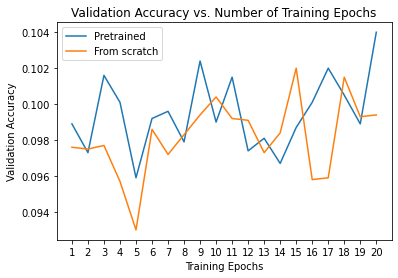

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,20+1), torch.Tensor(hist_resnet).cpu(), label="Pretrained")
plt.plot(range(1,20+1), torch.Tensor(model_hist).cpu(), label="From scratch")
# plt.ylim((0,1.))
plt.xticks(np.arange(1, 20+1, 1.0))
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

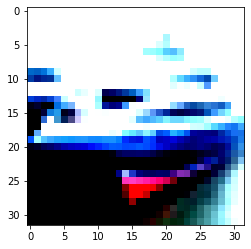

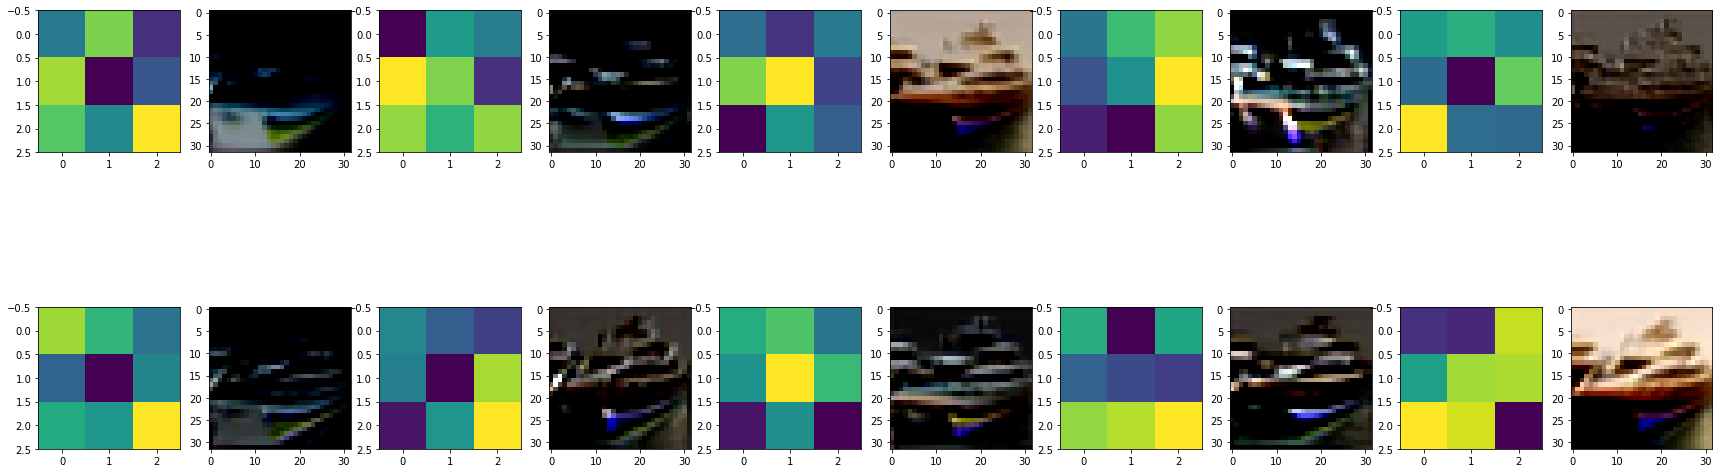

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

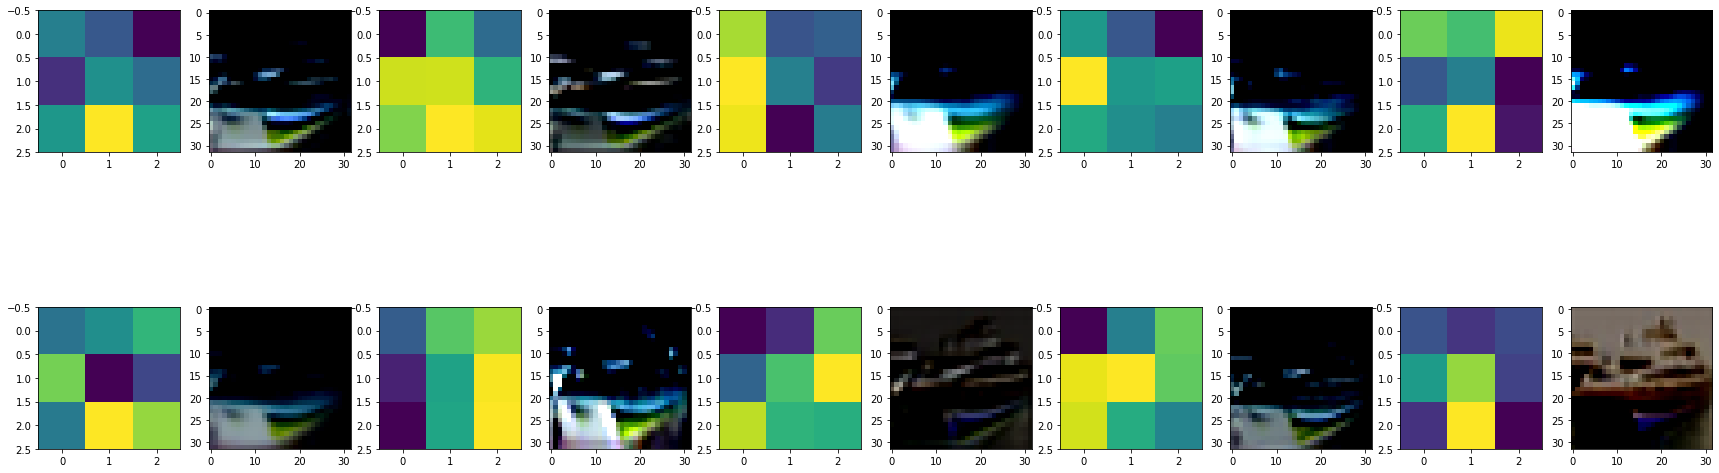

In [12]:
import cv2
from PIL import Image

model.eval()

# load one batch of testing images
dataiter = iter(test_data_loader)
images, labels = dataiter.next()
images = images.numpy()

# select an image by index
idx = 1
img = np.squeeze(images[idx])
# print(img.shape)

img = np.moveaxis(img, 0, -1)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# use OpenCV's filter2D function
# apply a specific set of filter weights (like the one's displayed above) to the test image
# print(img.shape)
plt.imshow(np.asarray(img))

# first conv layer - for 10 filters
weights = model.conv1.weight.data
w = weights.cpu().numpy()
fig=plt.figure(figsize=(30, 10))
columns = 10
rows = 2

for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0])
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(cv2.cvtColor(c, cv2.COLOR_BGR2RGB))
plt.show()

weights = model.conv2.weight.data
w = weights.cpu().numpy()
fig=plt.figure(figsize=(30, 10))
columns = 10
rows = 2

for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0])
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(cv2.cvtColor(c, cv2.COLOR_BGR2RGB))
plt.show()


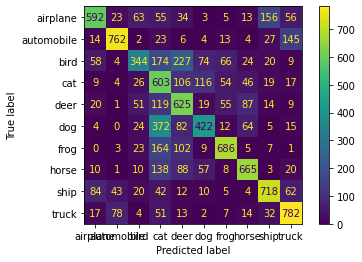

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pr = []
lb = []
dataiter = iter(test_data_loader)
for images, labels in dataiter:
    outputs = model(torch.Tensor((images)).cuda()).to("cuda")
    _, predicted = torch.max(outputs, 1)
    pr += predicted
    lb += labels
lb = torch.Tensor(lb).cpu()
pr = torch.Tensor(pr).cpu()
cm = confusion_matrix(lb, pr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=test.classes)
disp.plot()
plt.show()

In [74]:
accuracy= cm.diagonal()/cm.sum(axis=1) * 100
for acc, name in zip(accuracy, test.classes): 
    print(f"{name}: {acc} %")
print(f"top 1 error rate: {100 - min(accuracy)}%")

airplane: 59.199999999999996 %
automobile: 76.2 %
bird: 34.4 %
cat: 60.3 %
deer: 62.5 %
dog: 42.199999999999996 %
frog: 68.60000000000001 %
horse: 66.5 %
ship: 71.8 %
truck: 78.2 %
top 1 error rate: 65.6%


In [33]:
from sklearn.metrics import classification_report
print(classification_report(pr, lb, target_names=test.classes))

              precision    recall  f1-score   support

    airplane       0.59      0.73      0.65       808
  automobile       0.76      0.83      0.79       919
        bird       0.34      0.61      0.44       567
         cat       0.60      0.35      0.44      1741
        deer       0.62      0.48      0.54      1295
         dog       0.42      0.59      0.49       716
        frog       0.69      0.75      0.72       911
       horse       0.67      0.72      0.69       926
        ship       0.72      0.72      0.72      1001
       truck       0.78      0.70      0.74      1116

    accuracy                           0.62     10000
   macro avg       0.62      0.65      0.62     10000
weighted avg       0.64      0.62      0.62     10000



4.1 What kind of features did filters extract?

Фіча мапи - результат згортки фіч фільтрами.

4.2 Do you have "blind" filters that didn't learn anything? Why? How could you fix that?

В мене не було "сліпих" фільтрів. Але у випадку якби вони були можна зменшити розмір кернелів оскільки в нас зображення малої розмірності.

4.3 Does your model consider the background of the inputs?

Моя модель не враховує фон.

4.4 Does your model consider the colour of the inputs?

Моя модель приймає 3 канали на вхід, отже враховує колір.